<a href="https://colab.research.google.com/github/InbalBolshinsky/multi-modal-mutation-detector/blob/main/notebooks/LungCancer_ClinVar_DataPrep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the VCF file from ClinVar and extracting it.

In [1]:
import os

# File URL
url = "ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz"

# Check if the file exists
if not os.path.exists("clinvar.vcf.gz"):
    # Download the file
    !wget -O clinvar.vcf.gz {url}
    print("File downloaded.")
else:
    print("File already exists, skipping download.")

# Decompress the file
!gunzip -f clinvar.vcf.gz


--2024-12-15 21:52:50--  ftp://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
           => ‘clinvar.vcf.gz’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/clinvar/vcf_GRCh38 ... done.
==> SIZE clinvar.vcf.gz ... 104979789
==> PASV ... done.    ==> RETR clinvar.vcf.gz ... done.
Length: 104979789 (100M) (unauthoritative)

clinvar.vcf.gz      100%[===================>] 100.12M   393MB/s    in 0.3s    

2024-12-15 21:52:50 (393 MB/s) - ‘clinvar.vcf.gz’ saved [104979789]

File downloaded.


Viewing clinvar.vcf head:

In [2]:
!grep "CLNDN=" clinvar.vcf | head

1	69134	2205837	A	G	.	.	ALLELEID=2193183;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69134A>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Likely_benign;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69314	3205580	T	G	.	.	ALLELEID=3374047;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69314T>G;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69423	3205581	G	A	.	.	ALLELEID=3374048;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CLNHGVS=NC_000001.11:g.69423G>A;CLNREVSTAT=criteria_provided,_single_submitter;CLNSIG=Uncertain_significance;CLNVC=single_nucleotide_variant;CLNVCSO=SO:0001483;GENEINFO=OR4F5:79501;MC=SO:0001583|missense_variant;ORIGIN=1
1	69581	2252161	C	G	.	.	ALLELEID=2238986;CLNDISDB=MedGen:CN169374;CLNDN=not_specified;CL

Install Required Libraries and Import Modules

In [3]:
# Install necessary libraries
!pip install pysam

# Import required modules
import pysam
import pandas as pd
import os


Load the VCF File into a DataFrame

In [4]:
vcf_file = "clinvar.vcf"
columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]

# Use Pandas to read the VCF file
df = pd.read_csv(vcf_file, sep="\t", comment='#', names=columns, dtype={'CHROM': str}, low_memory=False)

Parse the INFO Field

In [5]:
# Parse INFO column into separate key-value pairs
def parse_info(info):
    parsed = {}
    for entry in info.split(";"):
        if "=" in entry:
            key, value = entry.split("=", 1)
            parsed[key] = value
    return parsed

# Apply parse_info to the INFO column
df["INFO"] = df["INFO"].apply(parse_info)

# Expand parsed INFO into separate columns
info_df = pd.DataFrame(df["INFO"].tolist(), index=df.index)
df = pd.concat([df.drop(columns=["INFO"]), info_df], axis=1)

In [6]:
info_df.head()

,ALLELEID,CLNDISDB,CLNDN,CLNHGVS,CLNREVSTAT,CLNSIG,CLNVC,CLNVCSO,GENEINFO,MC,...,ONCDN,ONCREVSTAT,SCI,SCIREVSTAT,DBVARID,SCIDISDB,SCIDN,ONCDISDBINCL,ONCDNINCL,ONCINCL
0,2193183,MedGen:CN169374,not_specified,NC_000001.11:g.69134A>G,"criteria_provided,_single_submitter",Likely_benign,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3374047,MedGen:CN169374,not_specified,NC_000001.11:g.69314T>G,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3374048,MedGen:CN169374,not_specified,NC_000001.11:g.69423G>A,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2238986,MedGen:CN169374,not_specified,NC_000001.11:g.69581C>G,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2386655,MedGen:CN169374,not_specified,NC_000001.11:g.69682G>A,"criteria_provided,_single_submitter",Uncertain_significance,single_nucleotide_variant,SO:0001483,OR4F5:79501,SO:0001583|missense_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check for Missing Columns and Pre-Filter Data

In [7]:
# Check for missing columns and handle them
if "GENEINFO" not in df.columns:
    print("Warning: GENEINFO column is missing. Please verify the VCF file format.")
    df["GENEINFO"] = None

if "CLNSIG" not in df.columns:
    print("Warning: CLNSIG column is missing. Please verify the VCF file format.")
    df["CLNSIG"] = None

# Pre-filter rows with non-null GENEINFO
df = df[df["GENEINFO"].notna()]

Define Genes and Classifications

In [8]:
# Define relevant genes and classifications
genes_of_interest = ["EGFR", "KRAS", "ALK"]
classifications = {
    "Pathogenic/Likely Pathogenic": ["Pathogenic", "Likely_pathogenic"],
    "Benign/Likely Benign": ["Benign", "Likely_benign"],
    "VUS": ["Uncertain_significance"]
}

Filter Data by Gene and Classification

In [9]:
# Filter Data by Gene and Classification
filtered_dfs = {}
for gene in genes_of_interest:
    for classification_name, classification_values in classifications.items():
        # Filter for specific gene and classification
        gene_class_mask = (
            df["GENEINFO"].str.contains(gene, na=False) &
            df["CLNSIG"].isin(classification_values)
        )
        key = f"{gene}_{classification_name.replace(' ', '_')}"
        filtered_dfs[key] = df[gene_class_mask]

Save Filtered DataFrames

In [10]:
df.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,ALLELEID,CLNDISDB,CLNDN,...,ONCDN,ONCREVSTAT,SCI,SCIREVSTAT,DBVARID,SCIDISDB,SCIDN,ONCDISDBINCL,ONCDNINCL,ONCINCL
0,1,69134,2205837,A,G,.,.,2193183,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,69314,3205580,T,G,.,.,3374047,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,69423,3205581,G,A,.,.,3374048,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,69581,2252161,C,G,.,.,2238986,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,69682,2396347,G,A,.,.,2386655,MedGen:CN169374,not_specified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Initializing dictionary to store filtered by gene dataFrames and viewing the count for each gene

In [11]:
# Define relevant genes and classifications
genes_of_interest = ["EGFR", "KRAS", "ALK"]
classifications = {
    "Pathogenic/Likely_Pathogenic": ["Pathogenic", "Likely_pathogenic"],
    "Benign/Likely_Benign": ["Benign", "Likely_benign"],
    "VUS": ["Uncertain_significance"]
}

# Initialize dictionary to store filtered DataFrames
filtered_dfs = {}

# Process data for each gene and classification
for gene in genes_of_interest:
    print(f"----------Processing gene: {gene}----------")
    for classification_name, classification_values in classifications.items():
        # Filter data for specific gene and classification
        filtered_df = df[
            (df["GENEINFO"].str.contains(gene, na=False)) &
            (df["CLNSIG"].isin(classification_values))
        ]
        count = len(filtered_df)
        print(f"{gene}_{classification_name.replace(' ', '_')}: {count}")
        # Store the filtered DataFrame in the dictionary
        key = f"{gene}_{classification_name.replace(' ', '_')}"
        filtered_dfs[key] = filtered_df

----------Processing gene: EGFR----------
EGFR_Pathogenic/Likely_Pathogenic: 119
EGFR_Benign/Likely_Benign: 1292
EGFR_VUS: 1409
----------Processing gene: KRAS----------
KRAS_Pathogenic/Likely_Pathogenic: 62
KRAS_Benign/Likely_Benign: 146
KRAS_VUS: 198
----------Processing gene: ALK----------
ALK_Pathogenic/Likely_Pathogenic: 131
ALK_Benign/Likely_Benign: 2458
ALK_VUS: 3432


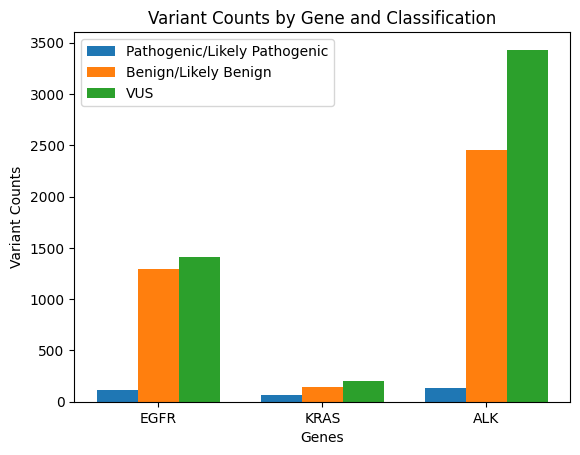

In [12]:
import matplotlib.pyplot as plt

# Data for visualization
genes = ["EGFR", "KRAS", "ALK"]
pathogenic_counts = [119, 62, 131]
benign_counts = [1292, 146, 2458]
vus_counts = [1409, 198, 3432]

# Plotting
bar_width = 0.25
x = range(len(genes))

plt.bar(x, pathogenic_counts, width=bar_width, label="Pathogenic/Likely Pathogenic")
plt.bar([p + bar_width for p in x], benign_counts, width=bar_width, label="Benign/Likely Benign")
plt.bar([p + 2 * bar_width for p in x], vus_counts, width=bar_width, label="VUS")

plt.xticks([p + bar_width for p in x], genes)
plt.xlabel("Genes")
plt.ylabel("Variant Counts")
plt.title("Variant Counts by Gene and Classification")
plt.legend()
plt.show()

Inspecting DataFrames:

In [13]:
for df_name, df in filtered_dfs.items():
    print(f"{df_name}: {len(df)} rows")


EGFR_Pathogenic/Likely_Pathogenic: 119 rows
EGFR_Benign/Likely_Benign: 1292 rows
EGFR_VUS: 1409 rows
KRAS_Pathogenic/Likely_Pathogenic: 62 rows
KRAS_Benign/Likely_Benign: 146 rows
KRAS_VUS: 198 rows
ALK_Pathogenic/Likely_Pathogenic: 131 rows
ALK_Benign/Likely_Benign: 2458 rows
ALK_VUS: 3432 rows


Data summary

In [14]:
# Access and analyze the DataFrames using the dictionary
for df_name, df in filtered_dfs.items():
    # Check if DataFrame is empty
    if df.empty:
        print(f"-------------- {df_name} is Empty ------------------\n")
        continue

    print(f"============== {df_name} Summary ==============\n")

    # General Information
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}\n")

    # Display basic statistics for numeric columns
    print("----- Descriptive Statistics for Numeric Columns -----\n")
    print(df.describe().to_string())  # Converts DataFrame to a cleaner string format
    print("\n")

    # Column types and non-null values
    print("----- Column Information -----\n")
    df_info = df.info(buf=None)  # Display without extra output clutter
    print("\n")

    # A small preview of the data
    print("----- Data Preview -----\n")
    print(df.head().to_string())  # Show first 5 rows in a clean table-like format
    print("\n")

    print("="*50)  # Separator for clarity


============== EGFR_Pathogenic/Likely_Pathogenic Summary ==============

Total rows: 119
Total columns: 39

----- Descriptive Statistics for Numeric Columns -----

                POS            ID
count  1.190000e+02  1.190000e+02
mean   5.517168e+07  1.345099e+06
std    2.254911e+04  9.847596e+05
min    5.501937e+07  4.522000e+04
25%    5.515622e+07  3.762765e+05
50%    5.517474e+07  1.058215e+06
75%    5.518141e+07  2.314642e+06
max    5.520554e+07  3.012073e+06


----- Column Information -----

<class 'pandas.core.frame.DataFrame'>
Index: 119 entries, 1147103 to 1149957
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CHROM         119 non-null    object
 1   POS           119 non-null    int64 
 2   ID            119 non-null    int64 
 3   REF           119 non-null    object
 4   ALT           119 non-null    object
 5   QUAL          119 non-null    object
 6   FILTER        119 non-null    object
 7   ALL

identifying null columns, analyzing their significance and dropping the non relevant columns found

In [15]:
for df_name, df in filtered_dfs.items():
    print(f"Columns with 0 non-nulls in {df_name}:")
    print(df.columns[df.isna().all()])
    print(len(df.columns))


Columns with 0 non-nulls in EGFR_Pathogenic/Likely_Pathogenic:
Index(['AF_TGP', 'AF_ESP', 'CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL',
       'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN'],
      dtype='object')
39
Columns with 0 non-nulls in EGFR_Benign/Likely_Benign:
Index(['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'ONC',
       'ONCDISDB', 'ONCDN', 'ONCREVSTAT', 'SCI', 'SCIREVSTAT', 'DBVARID',
       'SCIDISDB', 'SCIDN', 'ONCDISDBINCL', 'ONCDNINCL', 'ONCINCL'],
      dtype='object')
39
Columns with 0 non-nulls in EGFR_VUS:
Index(['CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL', 'CLNSIGINCL', 'SCI',
       'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN', 'ONCDISDBINCL',
       'ONCDNINCL', 'ONCINCL'],
      dtype='object')
39
Columns with 0 non-nulls in KRAS_Pathogenic/Likely_Pathogenic:
Index(['AF_TGP', 'AF_ESP', 'CLNSIGCONF', 'CLNDISDBINCL', 'CLNDNINCL',
       'CLNSIGINCL', 'SCI', 'SCIREVSTAT', 'DBVARID', 'SCIDISDB', 'SCIDN',
       'ONCDISDBINCL', 'ONCDNIN

In [18]:
# Identify dropped columns for each DataFrame
for df_name, df in filtered_dfs.items():
    original_columns = set(df.columns)
    non_null_columns = set(df.dropna(axis=1, how='all').columns)
    dropped_columns = original_columns - non_null_columns
    print(f"{df_name} - Dropped Columns:")
    print(dropped_columns)
    print("=" * 50)


EGFR_Pathogenic/Likely_Pathogenic - Dropped Columns:
set()
EGFR_Benign/Likely_Benign - Dropped Columns:
set()
EGFR_VUS - Dropped Columns:
set()
KRAS_Pathogenic/Likely_Pathogenic - Dropped Columns:
set()
KRAS_Benign/Likely_Benign - Dropped Columns:
set()
KRAS_VUS - Dropped Columns:
set()
ALK_Pathogenic/Likely_Pathogenic - Dropped Columns:
set()
ALK_Benign/Likely_Benign - Dropped Columns:
set()
ALK_VUS - Dropped Columns:
set()


In [17]:
# Iterate through the dictionary and drop columns with 0 non-null values
for df_name, df in filtered_dfs.items():
    # Drop columns with all NaN values
    filtered_dfs[df_name] = df.dropna(axis=1, how='all')

# Verify the changes
for df_name, df in filtered_dfs.items():
    print(f"After dropping empty columns, {df_name} has {len(df.columns)} columns.")


After dropping empty columns, EGFR_Pathogenic/Likely_Pathogenic has 28 columns.
After dropping empty columns, EGFR_Benign/Likely_Benign has 23 columns.
After dropping empty columns, EGFR_VUS has 27 columns.
After dropping empty columns, KRAS_Pathogenic/Likely_Pathogenic has 25 columns.
After dropping empty columns, KRAS_Benign/Likely_Benign has 23 columns.
After dropping empty columns, KRAS_VUS has 23 columns.
After dropping empty columns, ALK_Pathogenic/Likely_Pathogenic has 22 columns.
After dropping empty columns, ALK_Benign/Likely_Benign has 23 columns.
After dropping empty columns, ALK_VUS has 27 columns.


Analyzing the POS column

In [ ]:
import matplotlib.pyplot as plt

# Histogram for POS
plt.hist(df["POS"], bins=50, color='blue', alpha=0.7)
plt.title("Distribution of POS")
plt.xlabel("POS")
plt.ylabel("Frequency")
plt.show()


In [ ]:
print("Minimum POS:", df["POS"].min())
print("Maximum POS:", df["POS"].max())

hotspot_region = df[(df["POS"] >  2.8e5) & (df["POS"] < 2.9e5)]
print(hotspot_region.head())


In [ ]:
# Find most frequent POS values
print(df["POS"].value_counts().head())


In [ ]:
# Group by CHROM and summarize POS ranges
chrom_summary = df.groupby("CHROM")["POS"].agg(["min", "max", "count"])
print(chrom_summary)


In [ ]:
# Filter for Chromosome 2
chrom_2_data = df[df["CHROM"] == "2"]
print(chrom_2_data["POS"].value_counts().head())


In [ ]:
# Histogram for Chromosome 2
import matplotlib.pyplot as plt

plt.hist(chrom_2_data["POS"], bins=50, color="blue", alpha=0.7)
plt.title("POS Distribution in Chromosome 2")
plt.xlabel("POS")
plt.ylabel("Frequency")
plt.show()


In [ ]:
dense_region = chrom_2_data[(chrom_2_data["POS"] > 283000) & (chrom_2_data["POS"] < 300000)]
print(dense_region)

print(dense_region[["POS", "GENEINFO", "CLNDN", "CLNSIG"]].head())
